# 9章 データの集約とグループ演算
## 9.1 GroupByの仕組み

In [7]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas as pd
np.set_printoptions(precision=4)

In [8]:
df = DataFrame({'key1':['a','a','b','b','a'], 
              'key2':['one', 'two', 'one', 'two', 'one'], 
              'data1':np.random.randn(5), 
              'data2':np.random.randn(5)})

In [9]:
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


In [10]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [11]:
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [12]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [13]:
means.unstack()

key2,one,two
key1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


In [14]:
# グループキーは長さが同じ配列を使用することができる
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

In [15]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [16]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.880536  1.319920
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

In [17]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 9.1.1 グループをまたいだ繰り返し

In [21]:
for name, group in df.groupby(['key1', 'key2']):
    print name
    print group

('a', 'one')
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
4  1.965781  1.246435    a  one
('a', 'two')
      data1     data2 key1 key2
1  0.478943  0.092908    a  two
('b', 'one')
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
('b', 'two')
     data1     data2 key1 key2
3 -0.55573  0.769023    b  two


In [24]:
pieces = dict(list(df.groupby('key1')))

In [25]:
pieces['b']

,data1,data2,key1,key2
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two


In [28]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

### 9.1.2 列や列の集合の選択

In [32]:
df.groupby(['key1', 'key2'])['data1'].mean()

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

### 9.1.3 ディクショナリ形式やシリーズのグルーピング

In [33]:
people = DataFrame(np.random.randn(5, 5),
                   columns=['a', 'b', 'c', 'd', 'e'],
                   index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.ix[2:3, ['b', 'c']] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [34]:
mapping = {'a':'red', 'b':'red', 'c':'blue', 
          'd':'blue', 'e':'red', 'f':'orange'}

In [35]:
by_column = people.groupby(mapping, axis=1)

In [37]:
by_column.sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


### 9.1.4 関数を用いたグルーピング

In [39]:
# indexの文字の長さでグルーピング
people.groupby(len).sum()

,a,b,c,d,e
3,0.591569,-0.993608,0.798764,-0.791374,2.119639
5,0.886429,-2.001637,-0.371843,1.669025,-0.438570
6,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [40]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

### 9.1.5  インデックスレベルによるグルーピング

In [41]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]], names=['cty', 'tenor'])

In [42]:
columns

MultiIndex(levels=[[u'JP', u'US'], [1, 3, 5]],
           labels=[[1, 1, 1, 0, 0], [0, 1, 2, 0, 1]],
           names=[u'cty', u'tenor'])

In [43]:
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [44]:
# カラムの階層をしていして集約
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 9.2 データの集約

In [45]:
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


In [46]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

In [47]:
## 自分で作った集約関数を使うには、aggregateメソッド(aggメソッド)に渡す
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.170488,1.300498
b,0.036292,0.487276


In [48]:
grouped.describe()

data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.746672  0.910916
     std    1.109736  0.712217
     min   -0.204708  0.092908
     25%    0.137118  0.669671
     50%    0.478943  1.246435
     75%    1.222362  1.319920
     max    1.965781  1.393406
b    count  2.000000  2.000000
     mean  -0.537585  0.525384
     std    0.025662  0.344556
     min   -0.555730  0.281746
     25%   -0.546657  0.403565
     50%   -0.537585  0.525384
     75%   -0.528512  0.647203
     max   -0.519439  0.769023

In [49]:
tips = pd.read_csv('pydata-book/ch08/tips.csv')

In [50]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240


### 9.2.1 列に複数の関数を適用する

In [51]:
grouped = tips.groupby(['sex', 'smoker'])
grouped_pct = grouped['tip_pct']

In [52]:
grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [53]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

In [55]:
# 関数を適用したカラムの名称を与えるには(名前, 関数)というタプル形式で与える
grouped_pct.agg([('foo', 'mean'), ('bar', 'std')])

foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

In [57]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [58]:
# カラム毎に別の関数を適用させる場合
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

In [59]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

## 9.3 グループ思考の演算と変形

In [60]:
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


In [63]:
# ↑のデータフレームにkye1のグループ毎の平均値の列を追加したい

In [61]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [62]:
pd.merge(df, k1_means, left_on='key1', right_index=True)

,data1,data2,key1,key2,mean_data1,mean_data2
0,-0.204708,1.393406,a,one,0.746672,0.910916
1,0.478943,0.092908,a,two,0.746672,0.910916
4,1.965781,1.246435,a,one,0.746672,0.910916
2,-0.519439,0.281746,b,one,-0.537585,0.525384
3,-0.555730,0.769023,b,two,-0.537585,0.525384


In [64]:
# ↑これはあまり柔軟な方法ではない

In [65]:
key = ['one', 'two', 'one', 'two', 'one']
people.groupby(key).mean()
# peopleデータの各行にkeyを使ってカテゴリを指定
# そのカテゴリに対してgroupbyして、平均をとっている

,a,b,c,d,e
one,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
two,0.505275,-0.849512,0.075965,0.834983,0.452620


In [66]:
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
Steve,0.505275,-0.849512,0.075965,0.834983,0.452620
Wes,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
Jim,0.505275,-0.849512,0.075965,0.834983,0.452620
Travis,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309


In [67]:
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [68]:
def demean(arr):
    return arr - arr.mean()
demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,1.089221,-0.232534,1.322612,1.113271,1.381226
Steve,0.381154,-1.152125,-0.447807,0.834043,-0.891190
Wes,-0.457709,NaN,NaN,-0.136869,-0.548778
Jim,-0.381154,1.152125,0.447807,-0.834043,0.891190
Travis,-0.631512,0.232534,-1.322612,-0.976402,-0.832448


In [69]:
demeaned.groupby(key).mean()

,a,b,c,d,e
one,3.700743e-17,-1.110223e-16,0,7.401487e-17,0
two,-2.775558e-17,0.000000e+00,0,0.000000e+00,0


### 9.3.1 applyメソッド

In [70]:
def top(df, n=5, column='tip_pct'):
    return df.sort_index(by=column)[-n:]
top(tips, n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [71]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

In [72]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

### 9.3.2 分位点とビン分析

In [73]:
frame = DataFrame({'data1': np.random.randn(1000),
                   'data2': np.random.randn(1000)})
factor = pd.cut(frame.data1, 4)
factor[:10]

0     (-1.23, 0.489]
1    (-2.956, -1.23]
2     (-1.23, 0.489]
3     (0.489, 2.208]
4     (-1.23, 0.489]
5     (0.489, 2.208]
6     (-1.23, 0.489]
7     (-1.23, 0.489]
8     (0.489, 2.208]
9     (0.489, 2.208]
Name: data1, dtype: category
Categories (4, object): [(-2.956, -1.23] < (-1.23, 0.489] < (0.489, 2.208] < (2.208, 3.928]]

In [74]:
frame[:5]

,data1,data2
0,-0.919262,1.165148
1,-1.549106,-0.621249
2,0.022185,-0.799318
3,0.758363,0.777233
4,-0.660524,-0.612905


In [75]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-2.956, -1.23]",95,1.670835,-0.039521,-3.399312
"(-1.23, 0.489]",598,3.260383,-0.002051,-2.989741
"(0.489, 2.208]",297,2.954439,0.081822,-3.745356
"(2.208, 3.928]",10,1.765640,0.024750,-1.929776


In [76]:
# 分位点を返す
grouping = pd.qcut(frame.data1, 10, labels=False)

grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
0,100,1.670835,-0.049902,-3.399312
1,100,2.628441,0.030989,-1.950098
2,100,2.527939,-0.067179,-2.925113
3,100,3.260383,0.065713,-2.315555
4,100,2.074345,-0.111653,-2.047939
5,100,2.184810,0.052130,-2.989741
6,100,2.458842,-0.021489,-2.223506
7,100,2.954439,-0.026459,-3.056990
8,100,2.735527,0.103406,-3.745356
9,100,2.377020,0.220122,-2.064111


In [77]:
grouping[:10]

0    1
1    0
2    5
3    7
4    2
5    8
6    5
7    5
8    7
9    8
dtype: int64

### 9.3.3 例：グループ毎に指定する値で欠損値を埋める

In [78]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.125921
2         NaN
3   -0.884475
4         NaN
5    0.227290
dtype: float64

In [79]:
s.fillna(s.mean())

0   -0.261035
1   -0.125921
2   -0.261035
3   -0.884475
4   -0.261035
5    0.227290
dtype: float64

In [80]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = Series(np.random.randn(8), index=states)
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          0.922264
New York     -2.153545
Vermont            NaN
Florida      -0.375842
Oregon        0.329939
Nevada             NaN
California    1.105913
Idaho              NaN
dtype: float64

In [81]:
group_key

['East', 'East', 'East', 'East', 'West', 'West', 'West', 'West']

In [82]:
data.groupby(group_key).mean()

East   -0.535707
West    0.717926
dtype: float64

In [83]:
fill_mean = lambda g: g.fillna(g.mean())
fill_mean

<function __main__.<lambda>>

In [84]:
data.groupby(group_key).apply(fill_mean)

Ohio          0.922264
New York     -2.153545
Vermont      -0.535707
Florida      -0.375842
Oregon        0.329939
Nevada        0.717926
California    1.105913
Idaho         0.717926
dtype: float64

In [85]:
fill_values = {'East':0.5, 'West':-1}

In [86]:
fill_func = lambda g: g.fillna(fill_values[g.name])

In [87]:
data.groupby(group_key).apply(fill_func)

Ohio          0.922264
New York     -2.153545
Vermont       0.500000
Florida      -0.375842
Oregon        0.329939
Nevada       -1.000000
California    1.105913
Idaho        -1.000000
dtype: float64

### 9.3.4 例：ランダムサンプリングと順列

In [88]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (range(1, 11) + [10] * 3) * 4
base_names = ['A'] + range(2, 11) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = Series(card_val, index=cards)
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [90]:
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n])

draw(deck)

AD     1
8C     8
5H     5
KC    10
2C     2
dtype: int64

In [91]:
get_suit = lambda card: card[-1] # 最後の文字がカードのマークを表す
deck.groupby(get_suit).apply(draw, n=2)

C  2C     2
   3C     3
D  KD    10
   8D     8
H  KH    10
   3H     3
S  2S     2
   4S     4
dtype: int64

### 9.3.5 例：グループの加重平均と相関

In [92]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

,category,data,weights
0,a,1.561587,0.779796
1,a,0.022100,0.422211
2,a,0.546344,0.962321
3,a,0.385143,0.051641
4,b,0.303070,0.329897
5,b,-0.346796,0.576990
6,b,-0.317939,0.517064
7,b,-0.245498,0.337359


In [93]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.799965
b   -0.197201
dtype: float64

In [95]:
# yahoo! ファイナンスから取得したデータを使ってみる
# S&P500 の終値のデータ

close_px = pd.read_csv('pydata-book/ch09/stock_px.csv', parse_dates=True, index_col=0)
close_px[:10]

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93
2003-01-09,7.34,21.93,29.44,927.57
2003-01-10,7.36,21.97,29.03,927.57
2003-01-13,7.32,22.16,28.91,926.26
2003-01-14,7.30,22.39,29.17,931.66
2003-01-15,7.22,22.11,28.77,918.22


In [96]:
# 日次の利益とSPXとの年次の相関をみる

rets = close_px.pct_change().dropna()
spx_corr = lambda x: x.corrwith(x['SPX'])
by_year = rets.groupby(lambda x: x.year)

In [97]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1
2004,0.374283,0.588531,0.557742,1
2005,0.467540,0.562374,0.631010,1
2006,0.428267,0.406126,0.518514,1
2007,0.508118,0.658770,0.786264,1
2008,0.681434,0.804626,0.828303,1
2009,0.707103,0.654902,0.797921,1
2010,0.710105,0.730118,0.839057,1
2011,0.691931,0.800996,0.859975,1


In [99]:
# Appleとマイクロソフトの年次の相関
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 9.3.6 例：グループ指向の線形回帰

In [100]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    # 最小二乗法(OLS)によるデータの線形回帰
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [101]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 9.4 ピボットテーブルとクロス集計

In [103]:
tips.pivot_table(index=['sex', 'smoker'])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [104]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker')

tip_pct                size          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   0.165296  0.209129  2.500000  2.000000
       Sat   0.147993  0.163817  2.307692  2.200000
       Sun   0.165710  0.237075  3.071429  2.500000
       Thur  0.155971  0.163073  2.480000  2.428571
Male   Fri   0.138005  0.144730  2.000000  2.125000
       Sat   0.162132  0.139067  2.656250  2.629630
       Sun   0.158291  0.173964  2.883721  2.600000
       Thur  0.165706  0.164417  2.500000  2.300000

In [105]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker', margins=True)

tip_pct                          size                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   0.165296  0.209129  0.199388  2.500000  2.000000  2.111111
       Sat   0.147993  0.163817  0.156470  2.307692  2.200000  2.250000
       Sun   0.165710  0.237075  0.181569  3.071429  2.500000  2.944444
       Thur  0.155971  0.163073  0.157525  2.480000  2.428571  2.468750
Male   Fri   0.138005  0.144730  0.143385  2.000000  2.125000  2.100000
       Sat   0.162132  0.139067  0.151577  2.656250  2.629630  2.644068
       Sun   0.158291  0.173964  0.162344  2.883721  2.600000  2.810345
       Thur  0.165706  0.164417  0.165276  2.500000  2.300000  2.433333
All          0.159328  0.163196  0.160803  2.668874  2.408602  2.569672

In [107]:
tips.pivot_table('tip_pct', index=['sex', 'smoker'], columns='day',
                 aggfunc='count', margins=True)

day            Fri  Sat  Sun  Thur  All
sex    smoker                          
Female No        2   13   14    25   54
       Yes       7   15    4     7   33
Male   No        2   32   43    20   97
       Yes       8   27   15    10   60
All             19   87   76    62  244

### 9.4.1 crosstabメソッド：クロス集計

In [109]:
from StringIO import StringIO
data = """\
Sample    Gender    Handedness
1    Female    Right-handed
2    Male    Left-handed
3    Female    Right-handed
4    Male    Right-handed
5    Male    Left-handed
6    Male    Right-handed
7    Female    Right-handed
8    Female    Left-handed
9    Male    Right-handed
10    Female    Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')

In [111]:
data

,Sample,Gender,Handedness
0,1,Female,Right-handed
1,2,Male,Left-handed
2,3,Female,Right-handed
3,4,Male,Right-handed
4,5,Male,Left-handed
5,6,Male,Right-handed
6,7,Female,Right-handed
7,8,Female,Left-handed
8,9,Male,Right-handed
9,10,Female,Right-handed


In [110]:
pd.crosstab(data.Gender, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Gender,,,
Female,1,4,5
Male,2,3,5
All,3,7,10


In [112]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 9.5 例：2012年の連邦選挙委員会のデータベース

In [113]:
fec = pd.read_csv('pydata-book/ch09/P00000001-ALL.csv')

/Users/tokita/.pyenv/versions/anaconda3-2.1.0/envs/py2/lib/python2.7/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [116]:
fec.ix[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [117]:
unique_cands=fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [118]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

In [119]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [120]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [121]:
fec['party'] = fec.cand_nm.map(parties)
fec['party'].value_counts()

Democrat      593746
Republican    407985
dtype: int64

In [122]:
fec = fec[fec.contb_receipt_amt > 0]

In [123]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

### 9.5.1 職業と勤務先による寄付金の統計

In [124]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
dtype: int64

In [125]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# If no mapping provided, return x
# マッピングされない場合は、そのまま戻す
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

/Users/tokita/.pyenv/versions/anaconda3-2.1.0/envs/py2/lib/python2.7/site-packages/pandas/core/generic.py:2005: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [126]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [127]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')

In [128]:
# 合計200万ドル以上寄付した人を取り出す
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.430000
CEO,2074974.79,4211040.520000
CONSULTANT,2459912.71,2544725.450000
ENGINEER,951525.55,1818373.700000
EXECUTIVE,1355161.05,4138850.090000
HOMEMAKER,4248875.80,13634275.780000
INVESTOR,884133.00,2431768.920000
LAWYER,3160478.87,391224.320000
MANAGER,762883.22,1444532.370000


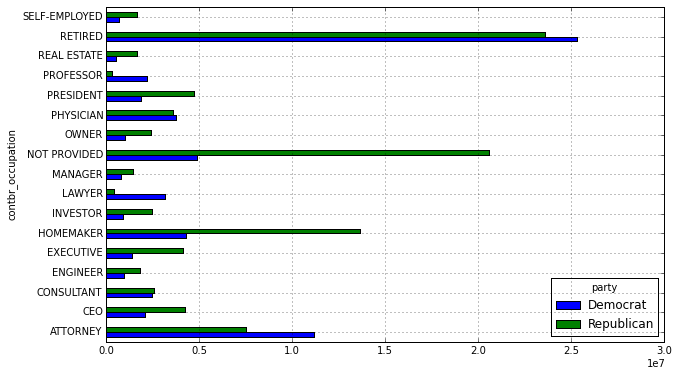

In [129]:
over_2mm.plot(kind='barh')

In [130]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()

    # Order totals by key in descending order
    return totals.order(ascending=False)[-n:]

In [131]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation                     
Obama, Barack  COMPUTER ASSISTANT                        3
               SPRINKLER FITTER FIRE PROTECTION SPECI    3
               ADMINISTRATION/INSTRUCTOR                 3
               LEAD UI/UX DEVELOPER                      3
               POLICY/ LAWYER                            3
               LAN/WAN ANALYST                           3
               SR MGR                                    3
Romney, Mitt   MD - UROLOGIST                            5
               DISTRICT REPRESENTATIVE                   5
               INDEPENDENT PROFESSIONAL                  3
               REMODELER & SEMI RETIRED                  3
               AFFORDABLE REAL ESTATE DEVELOPER          3
               IFC CONTRACTING SOLUTIONS                 3
               3RD GENERATION FAMILY BUSINESS OWNER      3
Name: contb_receipt_amt, dtype: float64

In [132]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer                   
Obama, Barack  SOLIYA                                3.0
               CARR ENTERPRISES                      3.0
               PENN STATE DICKINSON SCHOOL OF LAW    3.0
               CADUCEUS OCCUPATIONAL MEDICINE        3.0
               N.A.                                  3.0
               REAL ENERGY CONSULTING SERVICES       3.0
               JPDSYSTEMS, LLC                       3.0
               CASS REGIONAL MED. CENTER             2.5
               ARCON CORP                            2.0
               THE VICTORIA GROUP, INC.              2.0
Romney, Mitt   EASTHAM CAPITAL                       5.0
               GREGORY GALLIVAN                      5.0
               DIRECT LENDERS LLC                    5.0
               LOUGH INVESTMENT ADVISORY LLC         4.0
               WATERWORKS INDUSRTIES                 3.0
               WILL MERRIFIELD                       3.0
               HONOLD COMMUNICTAIONS  

### 9.5.2 寄付金額のビン分割

In [133]:
bins = np.array([0,1,10,100,1000,10000,100000,1000000,10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels

411           (10, 100]
412         (100, 1000]
413         (100, 1000]
414           (10, 100]
415           (10, 100]
416           (10, 100]
417         (100, 1000]
418           (10, 100]
419         (100, 1000]
420           (10, 100]
421           (10, 100]
422         (100, 1000]
423         (100, 1000]
424         (100, 1000]
425         (100, 1000]
426         (100, 1000]
427       (1000, 10000]
428         (100, 1000]
429         (100, 1000]
430           (10, 100]
431       (1000, 10000]
432         (100, 1000]
433         (100, 1000]
434         (100, 1000]
435         (100, 1000]
436         (100, 1000]
437           (10, 100]
438         (100, 1000]
439         (100, 1000]
440           (10, 100]
              ...      
701356        (10, 100]
701357          (1, 10]
701358        (10, 100]
701359        (10, 100]
701360        (10, 100]
701361        (10, 100]
701362      (100, 1000]
701363        (10, 100]
701364        (10, 100]
701365        (10, 100]
701366        (1

In [134]:
grouped = fec_mrbo.groupby(['cand_nm', labels])

In [135]:
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,NaN
"(1000000, 10000000]",4,NaN


In [138]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [139]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis = 0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


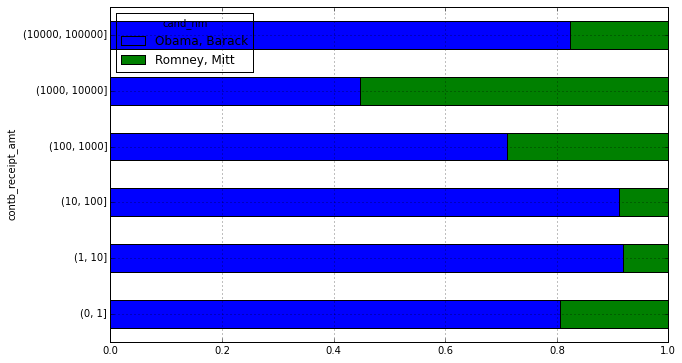

In [140]:
normed_sums[:-2].plot(kind='barh', stacked=True)

### 9.5.3 州別の寄付金の統計

In [141]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [142]:
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
